# Predicting Mental Health From Music


The goal of this notebook will be twofold. Firstly to provide us with a model for predicting the levels of depression, ocd, insomnia, anxiety from features mostly focused on the consumption of music. Secondly, to compare how much more effective the music features make the model in comparison to an equivalently constructed model which predicts these mental health problems from a subset consisting solely of age, hours time spent listening to music, and whether subject listens to music while working. Therby we estimate a solution to the question - Does the ***type*** of music one listens to have a deep relation with mental health.

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, regularizers, callbacks

### Cleaning Up The Data
We will be Removing categories not relevant to us. Secondly, we will levage one hot encoding for fav genres and ordinal encoding for the music genres. Lastly, we will segregate the data.

In [57]:
#read the data and clean it only keep relevant information (remove 'permissions', 'music effects', 'timestamp')
raw_dataset = pd.read_csv("survey.csv", sep=',')
dataset = raw_dataset.copy().drop(columns=['Permissions', 'Music effects', 'Timestamp', 'Primary streaming service'])
dataset.isna().dropna()
#initial data
dataset.tail()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD
731,17.0,2.0,Yes,Yes,No,Rock,Yes,Yes,120.0,Very frequently,...,Rarely,Very frequently,Never,Rarely,Very frequently,Never,7.0,6.0,0.0,9.0
732,18.0,1.0,Yes,Yes,No,Pop,Yes,Yes,160.0,Rarely,...,Never,Very frequently,Never,Never,Sometimes,Sometimes,3.0,2.0,2.0,5.0
733,19.0,6.0,Yes,No,Yes,Rap,Yes,No,120.0,Rarely,...,Rarely,Sometimes,Sometimes,Sometimes,Rarely,Rarely,2.0,2.0,2.0,2.0
734,19.0,5.0,Yes,Yes,No,Classical,No,No,170.0,Very frequently,...,Never,Never,Never,Never,Never,Sometimes,2.0,3.0,2.0,1.0
735,29.0,2.0,Yes,No,No,Hip hop,Yes,Yes,98.0,Sometimes,...,Never,Sometimes,Very frequently,Very frequently,Very frequently,Rarely,2.0,2.0,2.0,5.0


In [58]:
#do ordinal encoding for all the frequencies
for i in dataset.keys():
    if i[0:4] == 'Freq':
        dataset[i] = dataset[i].replace({'Never':0.0, 'Rarely': 1.0, 'Very frequently':3.0, 'Sometimes':2.0})
#fixes up No and Yes stuffs
for i in ['Instrumentalist', 'Composer', 'Foreign languages', 'Exploratory', 'While working']:
    dataset[i] = dataset[i].replace({'No': False, 'Yes': True})
cp = dataset.copy()
#one hot encoding for fav genre
dataset = pd.get_dummies(dataset, columns=['Fav genre'], prefix='', prefix_sep='')
dataset.tail()



/var/folders/9y/3t4kbvk12nz882r0ff7hyp540000gn/T/ipykernel_3104/1015111502.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset[i] = dataset[i].replace({'Never':0.0, 'Rarely': 1.0, 'Very frequently':3.0, 'Sometimes':2.0})
/var/folders/9y/3t4kbvk12nz882r0ff7hyp540000gn/T/ipykernel_3104/1015111502.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset[i] = dataset[i].replace({'No': False, 'Yes': True})


,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,Jazz,K pop,Latin,Lofi,Metal,Pop,R&B,Rap,Rock,Video game music
731,17.0,2.0,True,True,False,True,True,120.0,3.0,1.0,...,False,False,False,False,False,False,False,False,True,False
732,18.0,1.0,True,True,False,True,True,160.0,1.0,1.0,...,False,False,False,False,False,True,False,False,False,False
733,19.0,6.0,True,False,True,True,False,120.0,1.0,2.0,...,False,False,False,False,False,False,False,True,False,False
734,19.0,5.0,True,True,False,False,False,170.0,3.0,0.0,...,False,False,False,False,False,False,False,False,False,False
735,29.0,2.0,True,False,False,True,True,98.0,2.0,1.0,...,False,False,False,False,False,False,False,False,False,False


In [59]:
#all features
train_superset = dataset.sample(frac=0.9, random_state=0)
test_superset = dataset.drop(train_superset.index)

#only age and hours per day
train_subset = train_superset[['Age', 'Hours per day', 'While working', 'Depression', 'Insomnia', 'OCD', 'Anxiety']].copy()
test_subset = test_superset[['Age', 'Hours per day', 'While working', 'Depression', 'Insomnia', 'OCD', 'Anxiety']].copy()

train_subset.tail()



,Age,Hours per day,While working,Depression,Insomnia,OCD,Anxiety
227,30.0,1.0,False,10.0,2.0,0.0,8.0
143,53.0,7.0,True,0.0,0.0,0.0,0.0
180,17.0,2.0,True,3.0,1.0,5.0,7.0
131,28.0,6.0,True,8.0,7.0,1.0,10.0
699,16.0,9.0,True,10.0,10.0,8.0,10.0


## Modeling While Including Music-Type Features
> ### Plot the relations between depression and music types

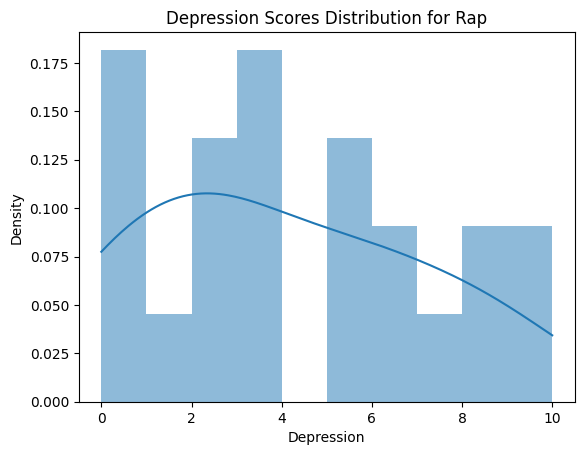

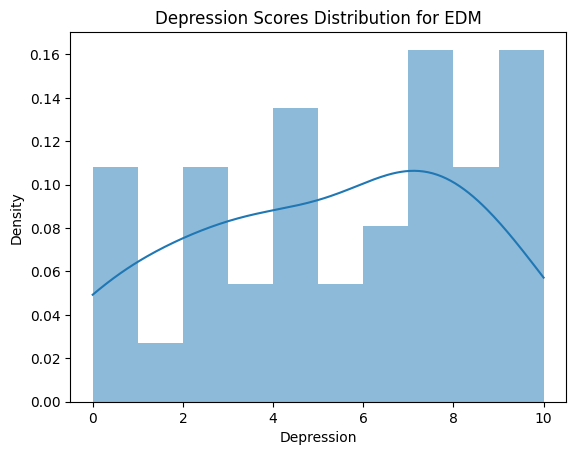

In [60]:
segmented_data = cp.groupby('Fav genre')['Depression'].value_counts().unstack(fill_value=0)
 
sns.histplot(data=cp[cp['Fav genre'] == "Rap"], x='Depression', kde=True, bins=10, stat='density', linewidth=0)
plt.title(f'Depression Scores Distribution for Rap')
plt.show()

sns.histplot(data=cp[cp['Fav genre'] == "EDM"], x='Depression', kde=True, bins=10, stat='density', linewidth=0)
plt.title(f'Depression Scores Distribution for EDM')
plt.show()


 Clearly the distribution is siginificantly different for EDM compared to rap, as it has much higher levels of depression. From this it becomes apparent that there is likely a strong relation between an individual's favorite genre and their risk of having high levels of depression. Furthermore, this would suggest that using frequency of categories might be prove to be effective way to predict the prevelance of mental health issues with more clarity -- as someone who listens to EDM very frequently might still have Rap as their favorite genre.

### Begin Creating The Model

In [61]:
#seperate the output from input
test_subset_labels = test_superset[['Depression', 'Insomnia', 'Anxiety', 'OCD']].copy().astype(np.float32)
test_subset = test_superset.drop(columns=['Depression', 'Insomnia', 'Anxiety', 'OCD']).copy().astype(np.float32)

train_superset_labels = train_superset[['Depression', 'Insomnia', 'Anxiety', 'OCD']].copy().astype(np.float32)
train_superset = train_superset.drop(columns=['Depression', 'Insomnia', 'Anxiety', 'OCD']).copy().astype(np.float32)

train_superset_labels.tail()

,Depression,Insomnia,Anxiety,OCD
227,10.0,2.0,8.0,0.0
143,0.0,0.0,0.0,0.0
180,3.0,1.0,7.0,5.0
131,8.0,7.0,10.0,1.0
699,10.0,10.0,10.0,8.0


> Create Normalizer Layer Since Our Data Has High Degrees of Variability Between Scales

In [62]:
train_superset = train_superset.fillna(train_superset.mean())

train_superset.replace([np.inf, -np.inf], np.nan, inplace=True)
train_superset = train_superset.fillna(train_superset.mean())

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_superset))
normalized_data = normalizer(train_superset)
print(normalized_data.numpy())

[[-0.514  0.475  0.51  ... -0.167  1.701 -0.247]
 [ 0.468  0.145  0.51  ... -0.167 -0.588 -0.247]
 [-0.596  0.145  0.51  ... -0.167 -0.588 -0.247]
 ...
 [-0.678 -0.516  0.51  ... -0.167  1.701 -0.247]
 [ 0.223  0.806  0.51  ... -0.167  1.701 -0.247]
 [-0.76   1.797  0.51  ... -0.167 -0.588 -0.247]]


> Create Model With 2 Dense Layers To Train On

In [63]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model
  
dnn_mh_Model = build_and_compile_model(normalizer)
dnn_mh_Model.summary()

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = dnn_mh_Model.fit(
    train_superset,
    train_superset_labels,
    validation_split=0.2,
    verbose=0, epochs=200, callbacks=[early_stopping])


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_6 (Normalization) │ (662, 40)              │            81 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (328.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 81 (328.00 B)

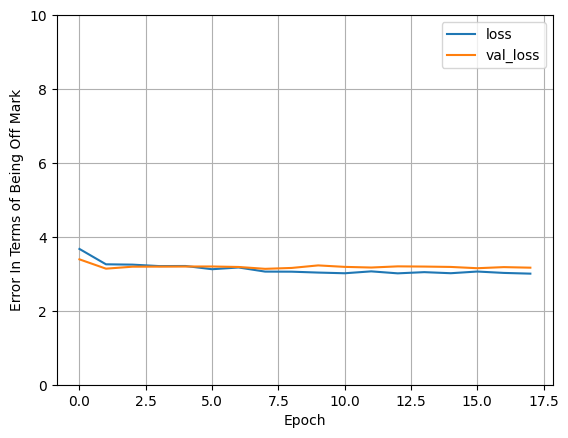

In [64]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error In Terms of Being Off Mark')
  plt.legend()
  plt.grid(True)

plot_loss(history)